**Преддипломная практика**

**Ядерные версии метода К-средних**

**Фазлетдинов Эдуард БПМИ184 ФКН ВШЭ**

### Импорт библиотек

In [1]:
import copy
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.special import comb
from sklearn.datasets import make_blobs, make_classification, make_circles, make_moons, make_hastie_10_2, make_gaussian_quantiles
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import gc
gc.enable()

### Определение ядерных функций и функций для оценки качества

In [2]:
class Kernels:
    def __init__(self):
        return

    @staticmethod
    def linear(x1, x2, c: float = None):
        """
        Линейное ядро
        ----------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: с: параметр смещения
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not c:
            c = 0

        return x1.dot(x2.T) + c

    @staticmethod
    def rbf(x1, x2, gamma: float = None):
        """
        RBF: Радиальное ядро или Гауссово ядро
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: gamma: параметр скейлинга
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        if x1.ndim == 1 and x2.ndim == 1:
            return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)
        elif (x1.ndim > 1 and x2.ndim == 1) or (x1.ndim == 1 and x2.ndim > 1):
            return np.exp(-gamma * np.linalg.norm(x1 - x2, axis=1) ** 2)
        elif x1.ndim > 1 and x2.ndim > 1:
            return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)

    @staticmethod
    def laplacian(x1, x2, gamma: float = None):
        """
        Ядро Лапласа
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: gamma: параметр скейлинга
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        if x1.ndim == 1 and x2.ndim == 1:
            return np.exp(-gamma * np.linalg.norm(x1 - x2))
        elif (x1.ndim > 1 and x2.ndim == 1) or (x1.ndim == 1 and x2.ndim > 1):
            return np.exp(-gamma * np.linalg.norm(x1 - x2, axis=1))
        elif x1.ndim > 1 and x2.ndim > 1:
            return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2))

    @staticmethod
    def polynomial(x1, x2, d: float = None, c: float = None):
        """
        Полиномиальное ядро
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: d: степень полинома
        :аргумент: с: параметр смещения
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not d:
            d = 1
        
        if not c:
            c = 0

        return (x1.dot(x2.T) + c) ** d

    @staticmethod
    def cosine(x1, x2):
        """
        Косинусовое сходство
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        return x1.dot(x2.T) / np.linalg.norm(x1, 1) * np.linalg.norm(x2, 1)

    @staticmethod
    def correlation(x1, x2, gamma: float = None):
        """
        Корреляционное ядро
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: gamma: параметр
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        return np.exp((x1.dot(x2.T) / np.linalg.norm(x1, 1) * np.linalg.norm(x2, 1)) - 1 / gamma)

    @staticmethod
    def linrbf(x1, x2, gamma : float = None, c: float = None, op: str = None):
        """
        Совмещение двух ядерных функций: линейного и гауссова
        ----------------------------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: gamma: параметр
        :аргумент: op: операция совмещения ('add', 'multiply', 'divide', 'subtract', 'dot'), по умолчанию прямое произведение
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        if not op:
            op = 'multiply'

        if not c:
            c = 0

        if op == 'multiply':
            return Kernels.linear(x1=x1, x2=x2, c=c) * Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'add':
            return Kernels.linear(x1=x1, x2=x2, c=c) + Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'divide':
            return Kernels.linear(x1=x1, x2=x2, c=c) / Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'subtract':
            return np.abs(Kernels.linear(x1=x1, x2=x2, c=c) - Kernels.rbf(x1=x1, x2=x2, gamma=gamma))
        elif op == 'dot':
            return Kernels.linear(x1=x1, x2=x2, c=c).dot(10000 * Kernels.rbf(x1=x1, x2=x2, gamma=gamma).T)

    @staticmethod
    def rbfpoly(x1, x2, d: float = None, gamma: float = None, c: float = None, op: float = None):
        """
        Совмещение двух ядерных функций: гауссова и полиномиального
        ------------------- ---------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: d: параметр
        :аргумент: gamma: параметр
        :аргумент: c: параметр cмещения
        :аргумент: op: операция совмещения ('add', 'multiply', 'divide', 'subtract', 'dot'), по умолчанию прямое произведение
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        if not d:
            d = 1
        
        if not c:
            c = 0

        if not op:
            op = 'multiply'

        if op == 'multiply':
            return Kernels.polynomial(x1=x1, x2=x2, d=d, c=c) * Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'add':
            return Kernels.polynomial(x1=x1, x2=x2, d=d, c=c) + Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'divide':
            return Kernels.polynomial(x1=x1, x2=x2, d=d, c=c) / Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'subtract':
            return np.abs(Kernels.polynomial(x1=x1, x2=x2, d=d, c=c) - Kernels.rbf(x1, x2, gamma=gamma))
        elif op == 'dot':
            return Kernels.polynomial(x1=x1, x2=x2, d=d, c=c).dot(10000 * Kernels.polynomial(x1=x1, x2=x2, d=d, c=c).T)

    @staticmethod
    def rbfcosine(x1, x2, gamma: float = None, op: float = None):
        """
        Совмещение двух ядерных функций: гауссова и косинусового
        ------------------- ---------------------------
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        :аргумент: gamma: параметр
        :аргумент: op: операция совмещения ('add', 'multiply', 'divide', 'subtract', 'dot'), по умолчанию прямое произведение
        :Возвращаемое значение: Преобразованная ядерной функцией матрица объектов-признаков K(x1, x2)
        """
        if not gamma:
            gamma = 1

        if not op:
            op = 'multiply'

        if op == 'multiply':
            return Kernels.cosine(x1=x1, x2=x2) * Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'add':
            return Kernels.cosine(x1=x1, x2=x2) + Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'divide':
            return Kernels.cosine(x1=x1, x2=x2) / Kernels.rbf(x1=x1, x2=x2, gamma=gamma)
        elif op == 'subtract':
            return np.abs(Kernels.cosine(x1=x1, x2=x2) - Kernels.rbf(x1, x2, gamma=gamma))
        elif op == 'dot':
            return Kernels.cosine(x1=x1, x2=x2).dot(10000 * Kernels.cosine(x1=x1, x2=x2).T)

In [3]:
def accuracy_multiclass(y, predicted) -> float:
    """
    Функция для подсчёта Accuracy

    :параметр: y: таргетные кластеры
    :параметр: predicted: предсказанные кластеры
    :Возвращаемое значение: среднее кол-во наблюдений, где предсказанный кластер совпадает с таргетным
    """
    return np.sum([y[ii] == predicted[ii] for ii in range(len(y)) if y[ii] == predicted[ii]]) / len(y)

def ari(y, predicted) -> float:
    """
    Функция для подсчёте меры ARI
    :параметр: y: таргетные кластеры
    :параметр: predicted: предсказанные кластеры
    :Возвращаемое значение: ARI
    """
    return adjusted_rand_score(y, predicted)

### Определение основного класса Kernel K-Means

In [4]:
class kkMeans(Kernels):
    def __init__(self, n_clusters: int = None, kernel: str = None, gamma: float = None
                 , d: float = None, c: float = None, op: str = None):
        """
        :аргумент: n_clusters: количество кластеров
        :аргумент: kernel: название ядерной функции 
        :аргумент: d: параметр
        :аргумент: gamma: параметр
        :аргумент: c: параметр смещения
        :аргумент: op: операция совмещения двух ядерных функций, может принимать
                        значения: ('add', 'multiply', 'divide', 'subtract', 'dot'),
                        по умолчанию прямое произведение
        """

        super().__init__()

        if not kernel:
            kernel = 'rbf'
        self.kernel = kernel

        if not gamma:
            gamma = 1
        self.gamma = gamma

        if not d:
            d = 1
        self.d = d

        if not c:
            c = 0
        self.c = c

        if not n_clusters:
            n_clusters = 2
        self.n_clusters = n_clusters

        if not op:
            op = 'multiply'
        self.op = op

        return


    def kernelize(self, x1, x2):
        """
        :аргумент: x1: Матрица объёктов-признаков
        :аргумент: x2: Матрица объектов-признаков
        """

        if self.kernel == 'linear':
            return Kernels.linear(x1=x1, x2=x2, c=self.c)
        elif self.kernel == 'rbf':
            return Kernels.rbf(x1=x1, x2=x2, gamma=self.gamma)
        elif self.kernel == 'polynomial':
            return Kernels.polynomial(x1=x1, x2=x2, d=self.d, c=self.c)
        elif self.kernel == 'cosine':
            return Kernels.cosine(x1=x1, x2=x2)
        elif self.kernel == 'correlation':
            return Kernels.correlation(x1=x1, x2=x2, gamma=self.gamma)
        elif self.kernel == 'linrbf':
            return Kernels.linrbf(x1=x1, x2=x2, gamma=self.gamma, c=self.c, op=self.op)
        elif self.kernel == 'rbfpoly':
            return Kernels.rbfpoly(x1=x1, x2=x2, d=self.d, gamma=self.gamma, c=self.c, op=self.op)
        elif self.kernel == 'rbfcosine':
            return Kernels.rbfcosine(x1=x1, x2=x2, gamma=self.gamma, op=self.op)
        elif self.kernel == 'laplace':
            return Kernels.laplacian(x1=x1, x2=x2, gamma=self.gamma)


    def distance(self, KX):
        """
        Функция подсчётета расстояния
        :аргумент: KX: матрица объектов-признаков, преобразованная ядерной функцией
        """
        self.dist_w = np.zeros(self.n_clusters)
        c_k_init = np.ones(KX.shape[0])

        for ii in range(self.n_clusters):
            self.c_k_indices = self.clusters == ii
            self.c_k = np.sum(c_k_init[self.c_k_indices])
            self.c_k_squared = np.square(self.c_k)
            self.KX_ii = KX[self.c_k_indices][:, self.c_k_indices]
            self.distance_ii[:, ii] += np.sum(self.KX_ii) / self.c_k_squared - 2 * \
                                       np.sum(KX[:, self.c_k_indices], axis=1) / self.c_k

        return self.distance_ii


    def fit_predict(self, X, iters: int = None, tolerance: float = None):
        """
        Функция преобразования матрицы и предсказывания кластеров
        :аргумент: X: матрица объект-признак
        :аргумент: iters: количество итераций до остановки
        :аргумент: tolerance: порог остановки
        """

        if not tolerance:
            tolerance = 0.0001
        self.tolerance = tolerance

        if not iters:
            iters = 300
        self.iters = iters

        self.X = X
        N, D = X.shape
        
        self.distance_ii = np.zeros((N, self.n_clusters))
        self.kx = self.kernelize(self.X, self.X)
        self.clusters = np.random.randint(self.n_clusters, size=N)

        for step in range(self.iters):
            self.distance_k = self.distance(self.kx)
            
            self.prev_clusters = self.clusters
            
            self.clusters = self.distance_k.argmin(axis=1)
            
            if ari(self.clusters, self.prev_clusters) >= 0.99:
                break
            #if 1 - float(np.sum((self.clusters - self.prev_clusters) == 0)) / N < self.tolerance:
            #    break

        return self

### Определение функций запуска, перебора параметров, тестирования, визуализации

In [5]:
def create_report(kernels: list = None) -> dict:
    """
    Функция создания пустого отчёта
    :аргумент: kernels: список ядер 
    :Возвращаемое значение: словарь вида ядро: кластеры, оптимальные параметры, время работы алгоритма и метрики качества
    """
    if kernels is None:
        kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

    kernel_outcome = {}
    for kernel in kernels:
        kernel_outcome[kernel] = {'clusters': [], 'time': []
                                  , 'ari': [], 'acc': []
                                  , 'best_gamma': [], 'best_d': [], 'best_c': []}
    return kernel_outcome

In [6]:
def get_best_parameters(X, y, kernel: str, n_clusters: int = 2, n_init: int = 5):
    """
    Функция подбора оптимальных параметров
    :аргумент: X: входные данные
    :аргумент: y: таргетные кластеры
    :аргумент: n_clusters: количество кластеров
    :аргумент: kernel: ядро
    :аргумент: n_init: количество прогонов Kernel KMeans для каждого набора параметров
    :Возвращаемое значение: best_gamma, best_d, best_c - оптимальные параметры для заданного ядра и набора данных
    """
    best_gamma = 1
    best_d = 1
    best_c = 0
    best_ari = -1
    
    if kernel in ('cosine'):
        return best_gamma, best_d, best_c   # нет параметров

    elif kernel in ('linear'):
        for c in np.linspace(0, 100, 10):   # перебор парамера с
            current_ari = 0
            # запуск n_init инициализаций
            for init in range(n_init):
                kmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, c=c).fit_predict(X)
                current_ari_init = ari(kmeans.clusters, y)
                if current_ari_init >= current_ari:
                    current_ari = current_ari_init
            
            if current_ari - best_ari > 0.001:  # сохраняем наилучшие параметры
                best_ari = current_ari
                best_c = c

    elif kernel in ('rbf', 'correlation', 'laplace', 'rbfcosine'):
        for gamma in np.linspace(0.0001, 10, 100):   # перебор парамера gamma
            current_ari = 0
            # запуск n_init инициализаций
            for init in range(n_init):
                kmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma).fit_predict(X)
                current_ari_init = ari(kmeans.clusters, y)
                if current_ari_init >= current_ari:
                    current_ari = current_ari_init

            if current_ari - best_ari > 0.001:  # сохраняем наилучшие параметры
                best_ari = current_ari
                best_gamma = gamma

    elif kernel in ('polynomial'):
         for d in np.linspace(1, 10, 10):    # перебор параметра d
            for c in np.linspace(0, 100, 10):   # перебор парамера с
                current_ari = 0
                # запуск n_init инициализаций
                for init in range(n_init):
                    kmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, d=d, c=c).fit_predict(X)
                    current_ari_init = ari(kmeans.clusters, y)
                    if current_ari_init >= current_ari:
                        current_ari = current_ari_init
            
                if current_ari - best_ari > 0.001:  # сохраняем наилучшие параметры
                    best_ari = current_ari
                    best_d = d
                    best_c = c

    elif kernel in ('linrbf'):
        for gamma in np.linspace(0.0001, 10, 100):   # перебор парамера gamma
            for c in np.linspace(0, 100, 10):   # перебор парамера с
                current_ari = 0
                # запуск n_init инициализаций
                for init in range(n_init):
                    kmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, c=c).fit_predict(X)
                    current_ari_init = ari(kmeans.clusters, y)
                    if current_ari_init >= current_ari:
                        current_ari = current_ari_init

                if current_ari - best_ari > 0.001:  # сохраняем наилучшие параметры
                    best_ari = current_ari
                    best_gamma = gamma
                    best_c = c

    elif kernel in ('rbfpoly'):
        for gamma in np.linspace(0.0001, 10, 10):   # перебор парамера gamma
            for d in np.linspace(1, 10, 10):    # перебор параметра d
                for c in np.linspace(0, 100, 10):   # перебор парамера с
                    current_ari = 0
                    # запуск n_init инициализаций
                    for init in range(n_init):
                        kmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, d=d, c=c).fit_predict(X)
                        current_ari_init = ari(kmeans.clusters, y)
                        if current_ari_init >= current_ari:
                            current_ari = current_ari_init

                    if current_ari - best_ari > 0.001:  # сохраняем наилучшие параметры
                        best_ari = current_ari
                        best_gamma = gamma
                        best_d = d
                        best_c = c
    
    return best_gamma, best_d, best_c

In [7]:
def run_kkmeans(data_dict: dict, kernels: list, n_clusters: int = 2, n_init:int = 5) -> dict:
    """
    Функция запуска алгоритма Kernel K-Means
    :аргумент: data_dict: словарь вида структура_данных: (X, y)
    :аргумент: kernels: список ядер
    :аргумент: n_clusters: количество кластеров
    :Возвращаемое значение: словарь с отчётом
    """
    report = {}
    
    # проходимся по всем типам данных
    for data_type, data in data_dict.items():
        
        # создаём пустой отчёт для каждого типа
        data_type_report = create_report(kernels)
        
        # проходимся по каждому набору для каждого типа
        for data_num, data_sample in enumerate(data):
            
            # проходимся по каждому ядру
            for kernel in kernels:
                print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}, START: {data_type}_{data_num}, {kernel}')
                
                if kernel == 'original_kmeans': # Обычный KMeans
                    # для обычного KMeans нет параметров
                    best_gamma = 0
                    best_d = 0
                    best_c = 0
                    
                    start_time = time.time()
                    
                    # запуск обычного KMeans
                    original_kmeans = KMeans(n_clusters=n_clusters).fit(data_sample[0])
                    predicted_clusters = original_kmeans.labels_

                    end_time = time.time() - start_time
                
                elif kernel == 'original_agglomerative': # Агломеративная кластеризация
                    # для агломеративной кластеризации нет параметров
                    best_gamma = 0
                    best_d = 0
                    best_c = 0
                    
                    start_time = time.time()
                    
                    # запуск агломеративной кластеризации
                    original_agglomerative = AgglomerativeClustering(n_clusters=n_clusters).fit(data_sample[0])
                    predicted_clusters = original_agglomerative.labels_

                    end_time = time.time() - start_time
                    
                else: # Kernel KMeans
                    # подбор оптимальных параметров
                    best_gamma, best_d, best_c = get_best_parameters(X=data_sample[0]
                                                                     , y=data_sample[1]
                                                                     , kernel=kernel
                                                                     , n_clusters=n_clusters)
                    # Запуск Kernel KMeans с оптимальными параметрами
                    current_clusters = None
                    predicted_clusters = None
                    current_ari = 0
                    best_ari = 0
                    for init in range(n_init):
                        start_time_cur = time.time()
                        kkmeans = kkMeans(n_clusters=n_clusters, kernel=kernel, gamma=best_gamma, d=best_d, c=best_c).fit_predict(data_sample[0])
                        end_time_cur = time.time() - start_time_cur
                        
                        current_clusters = kkmeans.clusters
                        
                        current_ari = round(ari(current_clusters, data_sample[1]), 3)
                        
                        if current_ari >= best_ari:
                            best_ari = current_ari
                            predicted_clusters = current_clusters
                            end_time = end_time_cur

                # заполнение отчёта
                data_type_report[kernel]['clusters'].append(predicted_clusters)
                data_type_report[kernel]['time'].append(end_time)
                data_type_report[kernel]['ari'].append(round(ari(predicted_clusters, data_sample[1]), 3))
                data_type_report[kernel]['acc'].append(round(accuracy_multiclass(predicted_clusters, data_sample[1]), 3))
                data_type_report[kernel]['best_gamma'].append(round(best_gamma, 3))
                data_type_report[kernel]['best_d'].append(round(best_d, 3))
                data_type_report[kernel]['best_c'].append(round(best_c, 3))

                # print('ARI:', round(ari(predicted_clusters, data_sample[1]), 3)
                #       , '\tacc:', round(accuracy_multiclass(predicted_clusters, data_sample[1]), 3)
                #       , '\tgamma:', round(best_gamma, 3)
                #       , '\td:', round(best_d, 3)
                #       , '\tc:', round(best_c, 3))
                print(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}, END: {data_type}_{data_num}, {kernel}\tARI:', round(ari(predicted_clusters, data_sample[1]), 3))
                
        # добавляем отчёт по текущему типу данных в общий отчёт
        report[f'{data_type}'] = data_type_report
    
    return report

In [8]:
def plot_report(data_dict: dict, kernels: list, report: dict):
    """
    Функция визуализации кластеризации (актуально только для кол-ва кластеров = 2)
    :аргумент: data_dict: словарь вида структура_данных: (X, y)
    :аргумент: kernels: список ядер
    :аргумент: report: отчёт, полученный на выход функцией run_kkmeans
    """
    np.random.seed(1000)
    plt.rcParams.update({'font.size': 8})
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['figure.dpi'] = 150
    mpl.rcParams.update(mpl.rcParamsDefault)

    count_data_types = len(data_dict)   # количество различных типов данных
    count_kernels = len(kernels)    # количество анализируемых ядерных функций

    s = 0.5 # размер точек на графике
    color = 'coolwarm_r'
    
    if count_data_types == 1:
        count_data_types += 1
    fig, ax = plt.subplots(count_data_types, count_kernels + 1, figsize=(15, 15), gridspec_kw=dict(hspace=0, wspace=0),
                           subplot_kw={'xticks': [], 'yticks': []})

    for i, (data_type, data) in enumerate(data_dict.items()):   # проходимся по всем типам данных
        ax[i, 0].scatter(data[0][0][:, 0], data[0][0][:, 1], c=data[0][1], s=s, cmap=color) # строим график для оригинала
        ax[i, 0].set_ylabel(data_type)  # проставляем название типа данных
        for j, (kernel, output) in enumerate(report[data_type].items()):    # строим график для каждой ядерной функции
            ax[i, j + 1].scatter(data[0][0][:, 0], data[0][0][:, 1], c=output['clusters'], s=s, cmap=color)

    ax[0, 0].set_title('Original')
    for j, (kernel, output) in enumerate(report[data_type].items()):    # проставляем название ядерных функций
        ax[0, j + 1].set_title(kernel)

    fig.set_tight_layout(True)
    plt.show()

In [9]:
def print_report(report: dict):
    """
    Функция вывода отчёта в виде текста
    :аргумент: report: словарь-отчёт
    """
    for data_type, report_dict in report.items():
        print(f'{data_type}')
        for kernel, metrics in report_dict.items():
            print(f'  {kernel}')
            for metric_name, metric in metrics.items():
                if metric_name == 'clusters':
                    continue
                print(f'    {metric_name}: {metric}')
        print(f'-------------------------------------------------')

In [10]:
def get_df_report(report: dict):
    """
    Функция получения датафрэйма из словаря-отчёта, 
    где элементами является список кортежей вида [('time': value), ('ari': value)]
    :аргумент: report: словарь-отчёт
    """
    new_report = copy.deepcopy(report)
    for data_type, kernel_dict in new_report.items():
        for kernel, metrics in kernel_dict.items():
            kernel_dict[kernel] = list({k: round(np.mean(v), 2)
                                        for k, v in metrics.items()
                                        if k not in ('clusters', 'best_gamma', 'best_d', 'best_c', 'acc')
                                        }.items())
    df_temp = pd.DataFrame.from_dict(new_report)
    return df_temp

In [11]:
def get_df_time_report(report: dict):
    """
    Функция получения датафрэйма из словаря-отчёта, 
    где элементами является время работы алгоритма
    :аргумент: report: словарь-отчёт
    """
    new_report = copy.deepcopy(report)
    for data_type, kernel_dict in new_report.items():
        for kernel, metrics in kernel_dict.items():
            kernel_dict[kernel] = round(np.mean([v for k, v in metrics.items()
                                        if k not in ('clusters', 'best_gamma', 'best_d', 'best_c', 'acc', 'ari')]), 2)
    df_temp = pd.DataFrame.from_dict(new_report)
    return df_temp

In [12]:
def get_df_mean_ari_report(report: dict):
    """
    Функция получения датафрэйма из словаря-отчёта, 
    где элементами являются средние значения ARI
    :аргумент: report: словарь-отчёт
    """
    new_report = copy.deepcopy(report)
    for data_type, kernel_dict in new_report.items():
        for kernel, metrics in kernel_dict.items():
            kernel_dict[kernel] = round(np.mean([v for k, v in metrics.items()
                                        if k not in ('clusters', 'best_gamma', 'best_d', 'best_c', 'acc', 'time')]), 2)
    df_temp = pd.DataFrame.from_dict(new_report)
    return df_temp

In [13]:
def get_df_std_ari_report(report: dict):
    """
    Функция получения датафрэйма из словаря-отчёта, 
    где элементами являются среднеквадратичные отклонения ARI для набора данных
    :аргумент: report: словарь-отчёт
    """
    new_report = copy.deepcopy(report)
    for data_type, kernel_dict in new_report.items():
        for kernel, metrics in kernel_dict.items():
            kernel_dict[kernel] = round(np.std([v for k, v in metrics.items()
                                        if k not in ('clusters', 'best_gamma', 'best_d', 'best_c', 'acc', 'time')]), 2)
    df_temp = pd.DataFrame.from_dict(new_report)
    return df_temp

In [14]:
def df_style(val):
    """
    Вспомогательная функция для выделения текста в датафрэйме жирным шрифтом
    """
    return "font-weight: bold"

### Эксперименты на 2 признаках с генерацией данных различной структуры

#### 2 кластера, 2 признака, 1000 объектов

In [15]:
samples = 1000  # количество объектов
n_features = 2  # количество признаков
n_clusters = 2  # количество генерируемых кластеров
random_state = 999

# тестовый набор со структурой дуги
dfmoon, ymoon = make_moons(n_samples=samples
                           , noise=0.01
                           , random_state=random_state)

# тестовый набор со структурой кольца
dfcircle, ycircle = make_circles(n_samples=samples
                                 , noise=0.01
                                 , factor=0.05
                                 , random_state=random_state)

# тестовый набор для кластеризации
dfclass1, yclass1 = make_classification(n_samples=samples
                                      , n_features=n_features
                                      , n_informative=2
                                      , n_redundant=0
                                      , n_repeated=0
                                      , n_classes=n_clusters
                                      , n_clusters_per_class=1
                                      , random_state=random_state)

# тестовый набор для кластеризации
dfclass2, yclass2 = make_classification(n_samples=samples
                                      , n_features=n_features
                                      , n_informative=2
                                      , n_redundant=0
                                      , n_repeated=0
                                      , n_classes=n_clusters
                                      , n_clusters_per_class=2
                                      , random_state=random_state)

# тестовый набор со структурой капель
dfblobs, yblobs = make_blobs(n_samples=samples
                             , centers=n_clusters
                             , n_features=n_features
                             , cluster_std=1
                             , random_state=random_state)

# тестовый набор с вложенными кластерами
dfgaussian, ygaussian = make_gaussian_quantiles(n_samples=samples
                                                , n_features=n_features
                                                , n_classes=n_clusters
                                                , random_state=random_state)

# заполняем входные данные по структурам
data_dict_2_2_1000 = {'moon': [(dfmoon, ymoon)], 'circle': [(dfcircle, ycircle)], 'class1': [(dfclass1, yclass1)],
             'class2': [(dfclass2, yclass2)], 'blobs': [(dfblobs, yblobs)], 'nested': [(dfgaussian, ygaussian)]}

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

In [16]:
# запуск алгоритма
report_2_2_1000 = run_kkmeans(data_dict=data_dict_2_2_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 14:37:38, START: moon_0, original_kmeans
2022-05-11 14:37:38, END: moon_0, original_kmeans	ARI: 0.251
2022-05-11 14:37:38, START: moon_0, polynomial
2022-05-11 14:38:24, END: moon_0, polynomial	ARI: 0.266
2022-05-11 14:38:24, START: moon_0, laplace
2022-05-11 14:39:24, END: moon_0, laplace	ARI: 0.689
2022-05-11 14:39:24, START: moon_0, rbf
2022-05-11 14:40:24, END: moon_0, rbf	ARI: 0.336
2022-05-11 14:40:24, START: moon_0, rbfpoly
2022-05-11 14:53:01, END: moon_0, rbfpoly	ARI: 0.593
2022-05-11 14:53:01, START: moon_0, original_agglomerative
2022-05-11 14:53:01, END: moon_0, original_agglomerative	ARI: 0.608
2022-05-11 14:53:01, START: circle_0, original_kmeans
2022-05-11 14:53:01, END: circle_0, original_kmeans	ARI: 0.168
2022-05-11 14:53:01, START: circle_0, polynomial
2022-05-11 14:54:06, END: circle_0, polynomial	ARI: 0.322
2022-05-11 14:54:06, START: circle_0, laplace
2022-05-11 14:54:48, END: circle_0, laplace	ARI: 0.348
2022-05-11 14:54:48, START: circle_0, rbf
2022-05

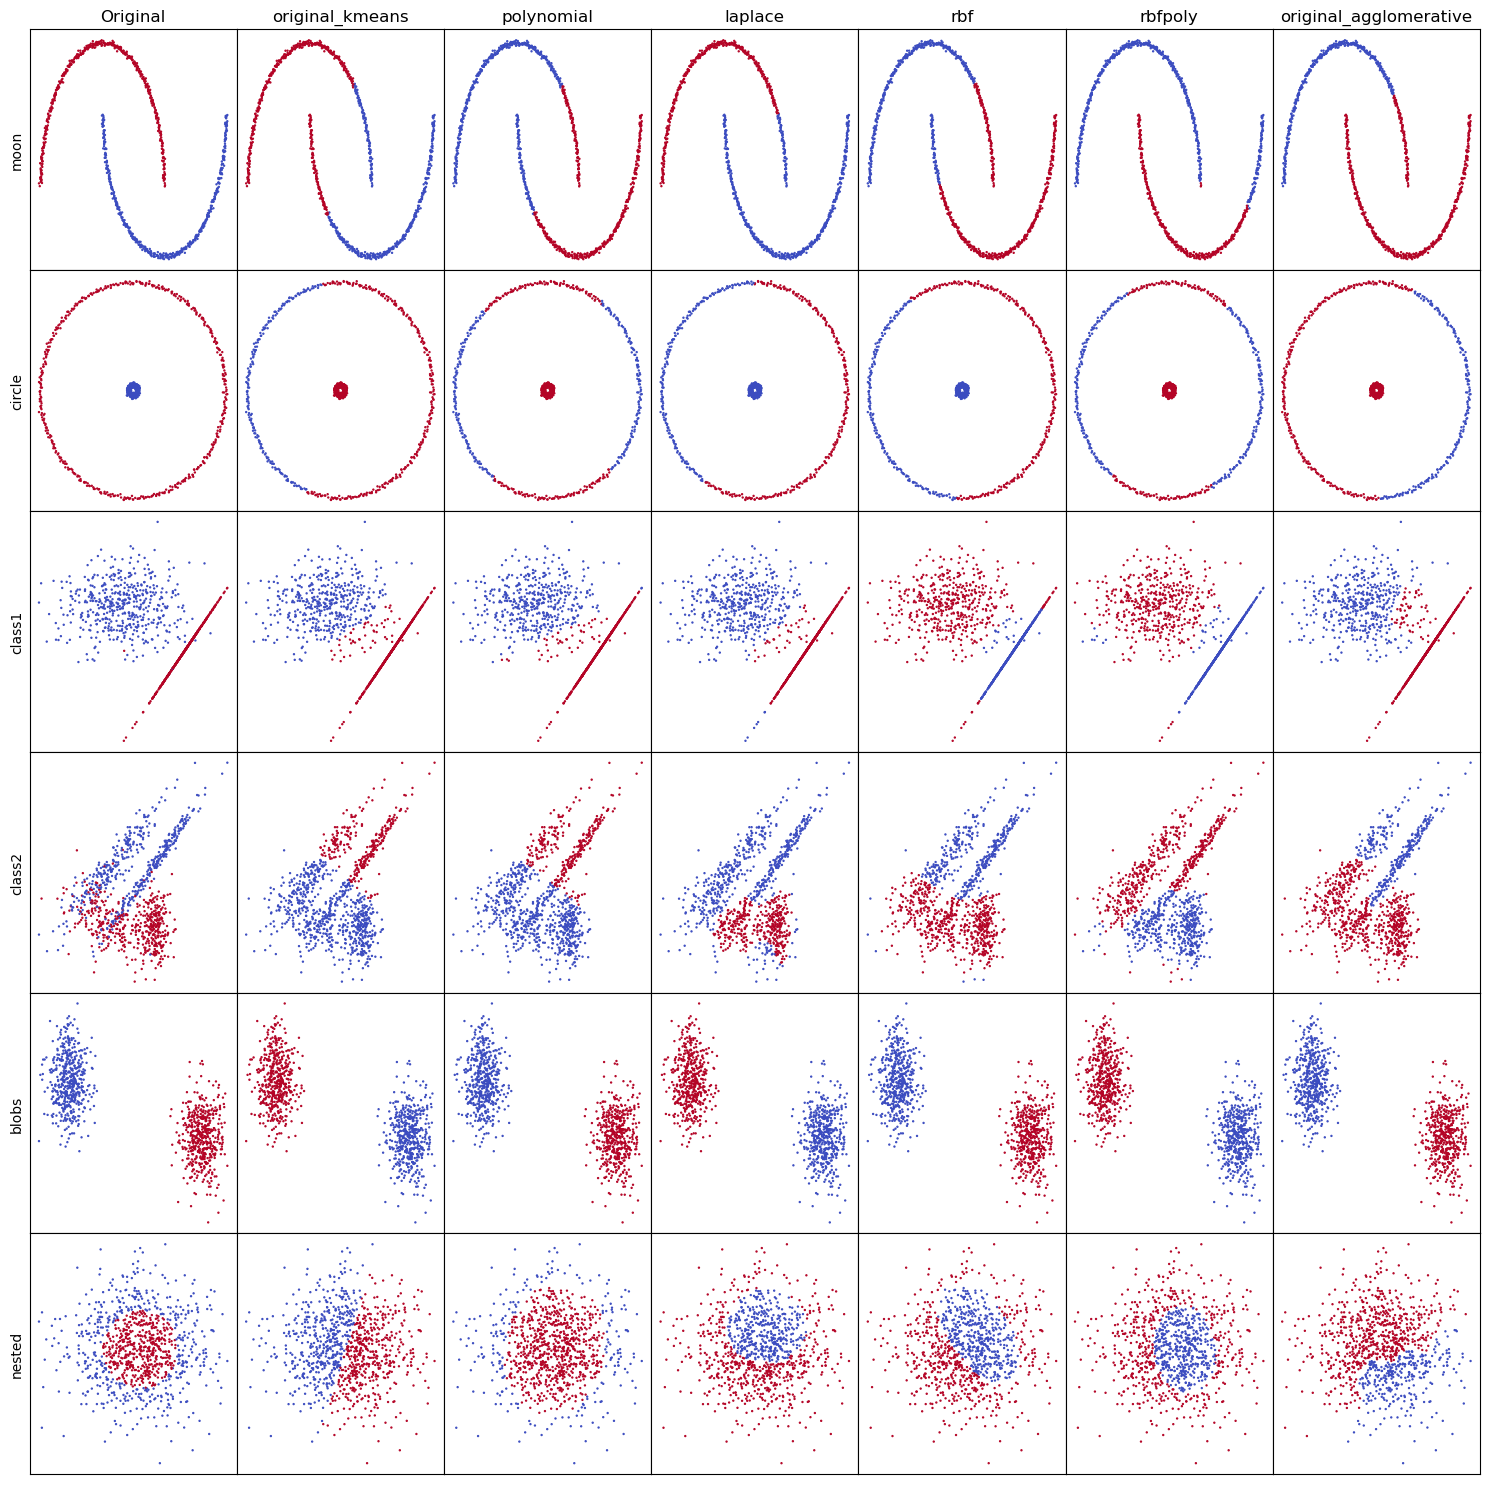

In [17]:
# построение визуализации
plot_report(data_dict=data_dict_2_2_1000, kernels=kernels, report=report_2_2_1000)

In [18]:
df_report_mean_ari_2_2_1000 = get_df_mean_ari_report(report_2_2_1000)
df_report_mean_ari_2_2_1000.style.format('{:.2f}', na_rep="").highlight_min(axis=0, props='color:red;').highlight_max(axis=0, props='color:green;font-weight:bold;').applymap(df_style)

,moon,circle,class1,class2,blobs,nested
original_kmeans,0.25,0.17,0.80,0.25,1.00,0.00
polynomial,0.27,0.32,0.80,0.28,1.00,0.19
laplace,0.69,0.35,0.81,0.40,1.00,0.19
rbf,0.34,0.36,0.79,0.52,1.00,0.18
rbfpoly,0.59,0.41,0.85,0.44,1.00,0.60
original_agglomerative,0.61,0.18,0.76,0.36,1.00,0.00


In [19]:
df_report_time_2_2_1000 = get_df_time_report(report_2_2_1000)
df_report_time_2_2_1000.style.format('{:.2f}', na_rep="").highlight_max(axis=0, props='color:red;').highlight_min(axis=0, props='color:green;font-weight:bold;').applymap(df_style)

,moon,circle,class1,class2,blobs,nested
original_kmeans,0.03,0.02,0.02,0.02,0.01,0.02
polynomial,0.09,0.12,0.14,0.09,0.03,0.10
laplace,0.22,0.10,0.11,0.15,0.06,0.12
rbf,0.07,0.12,0.08,0.12,0.07,0.17
rbfpoly,0.14,0.23,0.27,0.16,0.08,0.19
original_agglomerative,0.07,0.02,0.02,0.02,0.02,0.02


#### 3 кластера, 2 признака, 1000 объектов

In [20]:
samples = 1000  # количество объектов
n_features = 2  # количество признаков
n_clusters = 3  # количество генерируемых кластеров
random_state = 999


# тестовый набор с вложенными кластерами
dfgaussian, ygaussian = make_gaussian_quantiles(n_samples=samples
                                                , n_features=n_features
                                                , n_classes=n_clusters
                                                , random_state=random_state)

# тестовый набор для кластеризации
dfclass, yclass = make_classification(n_samples=samples
                                      , n_features=n_features
                                      , n_informative=2
                                      , n_redundant=0
                                      , n_repeated=0
                                      , n_classes=n_clusters
                                      , n_clusters_per_class=1
                                      , random_state=random_state)

# тестовый набор со структурой капель
dfblobs, yblobs = make_blobs(n_samples=samples
                             , centers=n_clusters
                             , n_features=n_features
                             , cluster_std=1
                             , random_state=random_state)

# заполняем входные данные по структурам
data_dict_3_2_1000 = {'class': [(dfclass, yclass)], 
                      'blobs': [(dfblobs, yblobs)], 
                      'nested': [(dfgaussian, ygaussian)]}

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

In [21]:
# запуск алгоритма
report_3_2_1000 = run_kkmeans(data_dict=data_dict_3_2_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 16:17:27, START: class_0, original_kmeans
2022-05-11 16:17:27, END: class_0, original_kmeans	ARI: 0.386
2022-05-11 16:17:27, START: class_0, polynomial
2022-05-11 16:18:20, END: class_0, polynomial	ARI: 0.492
2022-05-11 16:18:20, START: class_0, laplace
2022-05-11 16:19:31, END: class_0, laplace	ARI: 0.495
2022-05-11 16:19:31, START: class_0, rbf
2022-05-11 16:20:43, END: class_0, rbf	ARI: 0.513
2022-05-11 16:20:43, START: class_0, rbfpoly
2022-05-11 16:34:47, END: class_0, rbfpoly	ARI: 0.453
2022-05-11 16:34:47, START: class_0, original_agglomerative
2022-05-11 16:34:47, END: class_0, original_agglomerative	ARI: 0.493
2022-05-11 16:34:47, START: blobs_0, original_kmeans
2022-05-11 16:34:47, END: blobs_0, original_kmeans	ARI: 0.997
2022-05-11 16:34:47, START: blobs_0, polynomial
2022-05-11 16:35:27, END: blobs_0, polynomial	ARI: 1.0
2022-05-11 16:35:27, START: blobs_0, laplace
2022-05-11 16:36:26, END: blobs_0, laplace	ARI: 1.0
2022-05-11 16:36:26, START: blobs_0, rbf
2022-0

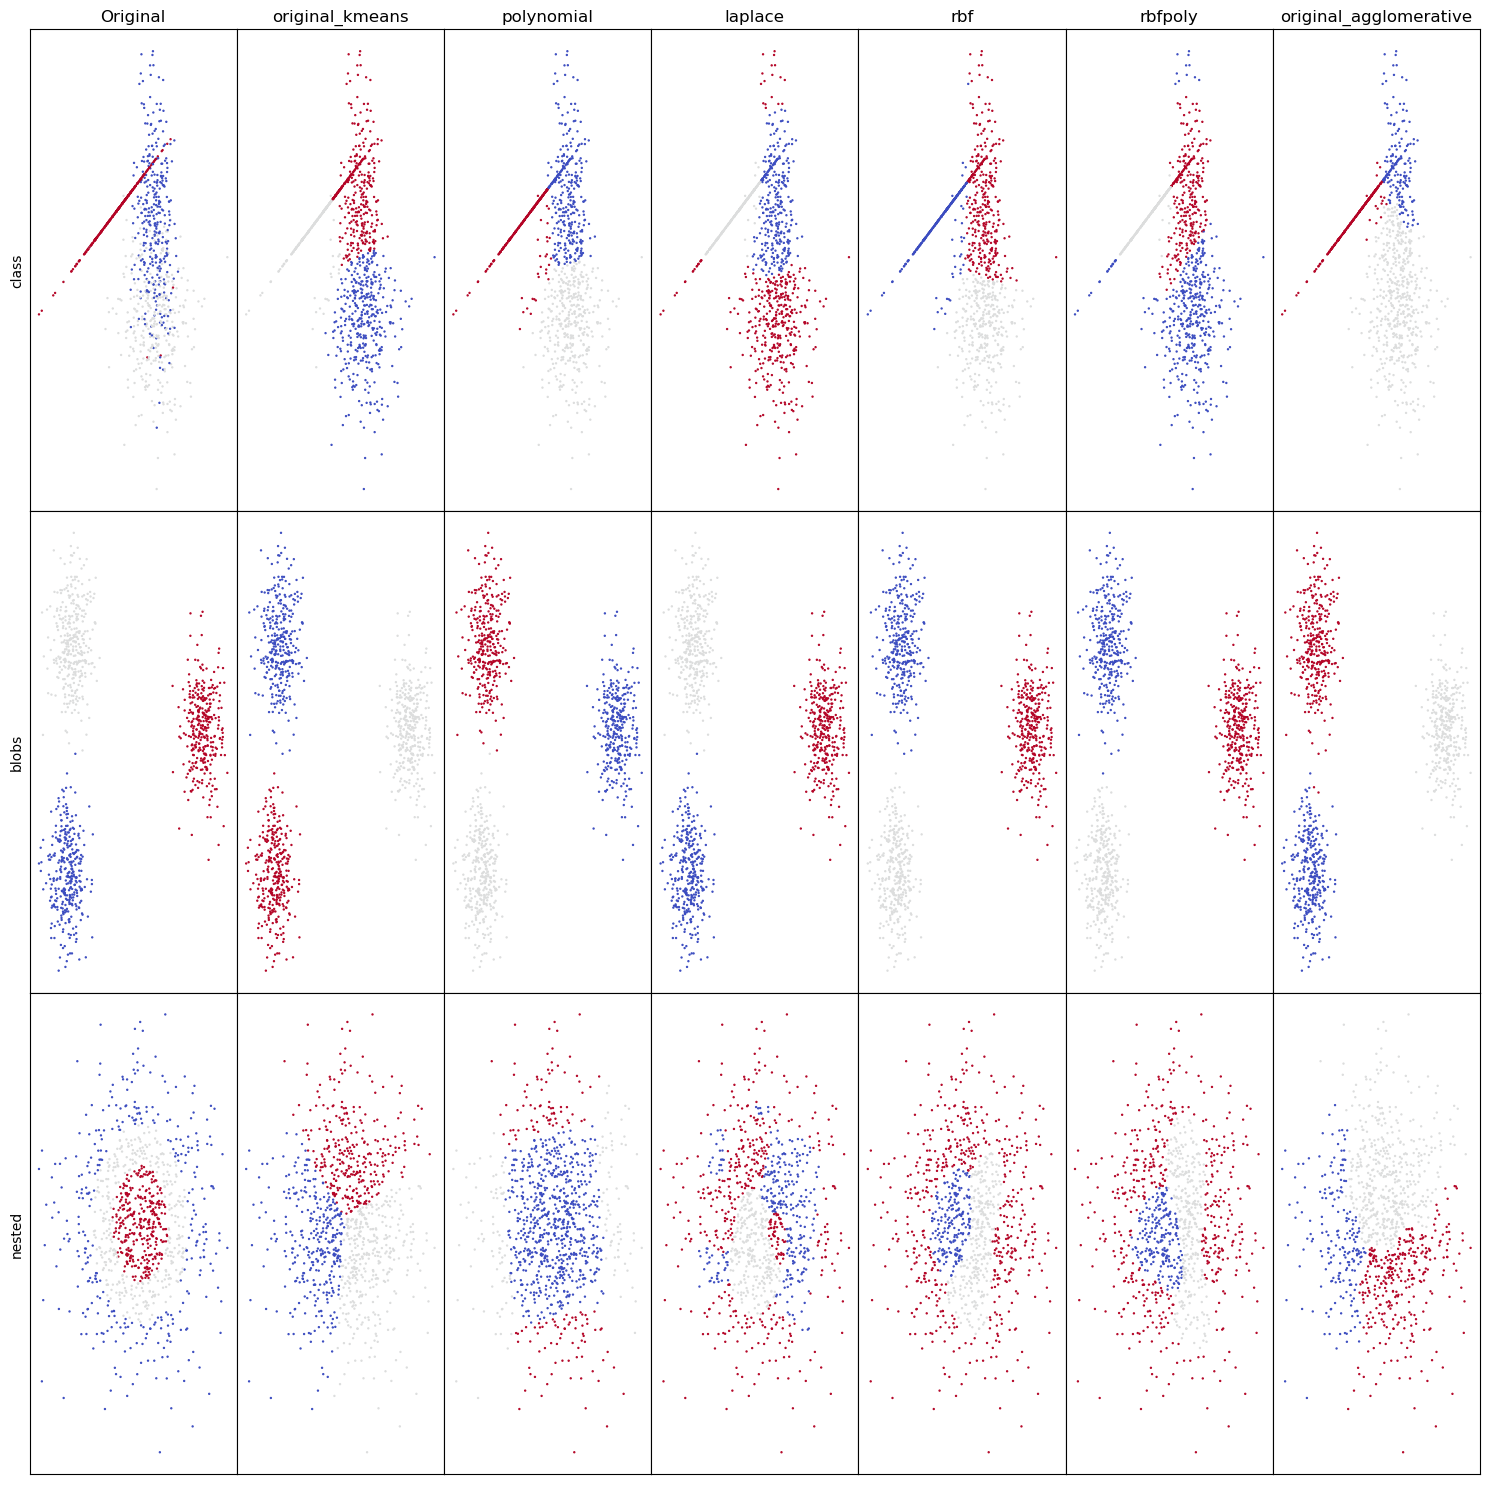

In [22]:
# построение визуализации
plot_report(data_dict=data_dict_3_2_1000, kernels=kernels, report=report_3_2_1000)

In [23]:
df_report_mean_ari_3_2_1000 = get_df_mean_ari_report(report_3_2_1000)
df_report_mean_ari_3_2_1000.style.format('{:.2f}', na_rep="").highlight_min(axis=0, props='color:red;').highlight_max(axis=0, props='color:green;font-weight:bold;').applymap(df_style)

,class,blobs,nested
original_kmeans,0.39,1.00,0.00
polynomial,0.49,1.00,0.31
laplace,0.50,1.00,0.14
rbf,0.51,1.00,0.32
rbfpoly,0.45,0.99,0.28
original_agglomerative,0.49,0.99,0.06


In [24]:
df_report_time_3_2_1000 = get_df_time_report(report_3_2_1000)
df_report_time_3_2_1000.style.format('{:.2f}', na_rep="").highlight_max(axis=0, props='color:red;').highlight_min(axis=0, props='color:green;font-weight:bold;').applymap(df_style)

,class,blobs,nested
original_kmeans,0.03,0.01,0.03
polynomial,0.09,0.03,0.05
laplace,0.15,0.06,0.17
rbf,0.18,0.06,0.15
rbfpoly,0.17,0.10,0.20
original_agglomerative,0.02,0.02,0.02


### Эксперименты на 7 и 20 признаках с генерацией пересекающихся кластеров

#### 3 кластера, 7 признаков, 1000 объектов

In [ ]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 3 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state)
    
    data_dict_3_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_3_7_1000 = run_kkmeans(data_dict=data_dict_3_7_1000, kernels=kernels, n_clusters=n_clusters)

In [26]:
df_report_mean_ari_3_7_1000 = get_df_mean_ari_report(report_3_7_1000)
df_report_mean_ari_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_7_features
laplace,0.38
original_agglomerative,0.32
original_kmeans,0.24
polynomial,0.36
rbf,0.33
rbfpoly,0.39


In [27]:
df_report_time_3_7_1000 = get_df_time_report(report_3_7_1000)
df_report_time_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.16
original_agglomerative,0.02
original_kmeans,0.04
polynomial,0.11
rbf,0.16
rbfpoly,0.19


In [28]:
df_report_std_3_7_1000 = get_df_std_ari_report(report_3_7_1000)
df_report_std_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.05
original_agglomerative,0.25
original_kmeans,0.08
polynomial,0.05
rbf,0.07
rbfpoly,0.11


#### 9 кластеров, 7 признаков, 1000 объектов

In [29]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 9 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_9_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state)
    
    data_dict_9_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_9_7_1000 = run_kkmeans(data_dict=data_dict_9_7_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-10 07:03:00, START: 9_clusters_7_features_0, original_kmeans
2022-05-10 07:03:00, END: 9_clusters_7_features_0, original_kmeans	ARI: 0.24
2022-05-10 07:03:00, START: 9_clusters_7_features_0, polynomial
2022-05-10 07:04:09, END: 9_clusters_7_features_0, polynomial	ARI: 0.253
2022-05-10 07:04:09, START: 9_clusters_7_features_0, laplace
2022-05-10 07:04:52, END: 9_clusters_7_features_0, laplace	ARI: 0.242
2022-05-10 07:04:52, START: 9_clusters_7_features_0, rbf
2022-05-10 07:05:36, END: 9_clusters_7_features_0, rbf	ARI: 0.17
2022-05-10 07:05:36, START: 9_clusters_7_features_0, rbfpoly
2022-05-10 07:20:55, END: 9_clusters_7_features_0, rbfpoly	ARI: 0.223
2022-05-10 07:20:55, START: 9_clusters_7_features_0, original_agglomerative
2022-05-10 07:20:55, END: 9_clusters_7_features_0, original_agglomerative	ARI: 0.217
2022-05-10 07:20:55, START: 9_clusters_7_features_1, original_kmeans
2022-05-10 07:20:55, END: 9_clusters_7_features_1, original_kmeans	ARI: 0.196
2022-05-10 07:20:55, STAR

In [30]:
df_report_mean_ari_9_7_1000 = get_df_mean_ari_report(report_9_7_1000)
df_report_mean_ari_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,9_clusters_7_features
laplace,0.20
original_agglomerative,0.21
original_kmeans,0.23
polynomial,0.23
rbf,0.20
rbfpoly,0.21


In [31]:
df_report_time_9_7_1000 = get_df_time_report(report_9_7_1000)
df_report_time_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_7_features
laplace,0.14
original_agglomerative,0.02
original_kmeans,0.06
polynomial,0.10
rbf,0.16
rbfpoly,0.18


In [32]:
df_report_std_9_7_1000 = get_df_std_ari_report(report_9_7_1000)
df_report_std_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_7_features
laplace,0.03
original_agglomerative,0.02
original_kmeans,0.02
polynomial,0.03
rbf,0.03
rbfpoly,0.03


#### 15 кластеров, 7 признаков, 1000 объектов

In [33]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 15 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_15_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state)
    
    data_dict_15_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_15_7_1000 = run_kkmeans(data_dict=data_dict_15_7_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-10 08:30:56, START: 15_clusters_7_features_0, original_kmeans
2022-05-10 08:30:57, END: 15_clusters_7_features_0, original_kmeans	ARI: 0.181
2022-05-10 08:30:57, START: 15_clusters_7_features_0, polynomial
2022-05-10 08:31:59, END: 15_clusters_7_features_0, polynomial	ARI: 0.167
2022-05-10 08:31:59, START: 15_clusters_7_features_0, laplace
2022-05-10 08:32:41, END: 15_clusters_7_features_0, laplace	ARI: 0.168
2022-05-10 08:32:41, START: 15_clusters_7_features_0, rbf
2022-05-10 08:33:24, END: 15_clusters_7_features_0, rbf	ARI: 0.152
2022-05-10 08:33:24, START: 15_clusters_7_features_0, rbfpoly
2022-05-10 08:48:29, END: 15_clusters_7_features_0, rbfpoly	ARI: 0.149
2022-05-10 08:48:29, START: 15_clusters_7_features_0, original_agglomerative
2022-05-10 08:48:29, END: 15_clusters_7_features_0, original_agglomerative	ARI: 0.171
2022-05-10 08:48:29, START: 15_clusters_7_features_1, original_kmeans
2022-05-10 08:48:29, END: 15_clusters_7_features_1, original_kmeans	ARI: 0.159
2022-05-1

In [34]:
df_report_mean_ari_15_7_1000 = get_df_mean_ari_report(report_15_7_1000)
df_report_mean_ari_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,15_clusters_7_features
laplace,0.15
original_agglomerative,0.16
original_kmeans,0.17
polynomial,0.17
rbf,0.15
rbfpoly,0.15


In [35]:
df_report_time_15_7_1000 = get_df_time_report(report_15_7_1000)
df_report_time_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_7_features
laplace,0.14
original_agglomerative,0.02
original_kmeans,0.10
polynomial,0.09
rbf,0.14
rbfpoly,0.17


In [36]:
df_report_std_15_7_1000 = get_df_std_ari_report(report_15_7_1000)
df_report_std_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_7_features
laplace,0.01
original_agglomerative,0.01
original_kmeans,0.01
polynomial,0.01
rbf,0.01
rbfpoly,0.01


#### 3 кластера, 20 признаков, 1000 объектов

In [37]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 3 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state)
    
    data_dict_3_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_3_20_1000 = run_kkmeans(data_dict=data_dict_3_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-10 09:58:39, START: 3_clusters_20_features_0, original_kmeans
2022-05-10 09:58:39, END: 3_clusters_20_features_0, original_kmeans	ARI: 0.193
2022-05-10 09:58:39, START: 3_clusters_20_features_0, polynomial
2022-05-10 09:59:47, END: 3_clusters_20_features_0, polynomial	ARI: 0.325
2022-05-10 09:59:47, START: 3_clusters_20_features_0, laplace
2022-05-10 10:01:14, END: 3_clusters_20_features_0, laplace	ARI: 0.352
2022-05-10 10:01:14, START: 3_clusters_20_features_0, rbf
2022-05-10 10:02:51, END: 3_clusters_20_features_0, rbf	ARI: 0.164
2022-05-10 10:02:51, START: 3_clusters_20_features_0, rbfpoly
2022-05-10 10:27:08, END: 3_clusters_20_features_0, rbfpoly	ARI: 0.576
2022-05-10 10:27:08, START: 3_clusters_20_features_0, original_agglomerative
2022-05-10 10:27:08, END: 3_clusters_20_features_0, original_agglomerative	ARI: 0.69
2022-05-10 10:27:08, START: 3_clusters_20_features_1, original_kmeans
2022-05-10 10:27:09, END: 3_clusters_20_features_1, original_kmeans	ARI: 0.202
2022-05-10

In [38]:
df_report_mean_ari_3_20_1000 = get_df_mean_ari_report(report_3_20_1000)
df_report_mean_ari_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_20_features
laplace,0.32
original_agglomerative,0.44
original_kmeans,0.25
polynomial,0.31
rbf,0.26
rbfpoly,0.39


In [39]:
df_report_time_3_20_1000 = get_df_time_report(report_3_20_1000)
df_report_time_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_20_features
laplace,0.26
original_agglomerative,0.02
original_kmeans,0.04
polynomial,0.13
rbf,0.26
rbfpoly,0.29


In [40]:
df_report_std_3_20_1000 = get_df_std_ari_report(report_3_20_1000)
df_report_std_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_20_features
laplace,0.06
original_agglomerative,0.13
original_kmeans,0.08
polynomial,0.10
rbf,0.09
rbfpoly,0.17


#### 9 кластеров, 20 признаков, 1000 объектов

In [42]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 9 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_9_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state)
    
    data_dict_9_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_9_20_1000 = run_kkmeans(data_dict=data_dict_9_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-10 15:52:55, START: 9_clusters_20_features_0, original_kmeans
2022-05-10 15:52:55, END: 9_clusters_20_features_0, original_kmeans	ARI: 0.126
2022-05-10 15:52:55, START: 9_clusters_20_features_0, polynomial
2022-05-10 15:53:57, END: 9_clusters_20_features_0, polynomial	ARI: 0.099
2022-05-10 15:53:57, START: 9_clusters_20_features_0, laplace
2022-05-10 15:55:18, END: 9_clusters_20_features_0, laplace	ARI: 0.109
2022-05-10 15:55:18, START: 9_clusters_20_features_0, rbf
2022-05-10 15:56:49, END: 9_clusters_20_features_0, rbf	ARI: 0.094
2022-05-10 15:56:49, START: 9_clusters_20_features_0, rbfpoly
2022-05-10 16:20:20, END: 9_clusters_20_features_0, rbfpoly	ARI: 0.105
2022-05-10 16:20:20, START: 9_clusters_20_features_0, original_agglomerative
2022-05-10 16:20:20, END: 9_clusters_20_features_0, original_agglomerative	ARI: 0.135
2022-05-10 16:20:20, START: 9_clusters_20_features_1, original_kmeans
2022-05-10 16:20:20, END: 9_clusters_20_features_1, original_kmeans	ARI: 0.124
2022-05-1

In [43]:
df_report_mean_ari_9_20_1000 = get_df_mean_ari_report(report_9_20_1000)
df_report_mean_ari_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,9_clusters_20_features
laplace,0.11
original_agglomerative,0.13
original_kmeans,0.13
polynomial,0.13
rbf,0.10
rbfpoly,0.11


In [44]:
df_report_time_9_20_1000 = get_df_time_report(report_9_20_1000)
df_report_time_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_20_features
laplace,0.23
original_agglomerative,0.02
original_kmeans,0.08
polynomial,0.10
rbf,0.24
rbfpoly,0.26


In [45]:
df_report_std_9_20_1000 = get_df_std_ari_report(report_9_20_1000)
df_report_std_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_20_features
laplace,0.01
original_agglomerative,0.02
original_kmeans,0.02
polynomial,0.02
rbf,0.01
rbfpoly,0.01


#### 15 кластеров, 20 признаков, 1000 объектов

In [144]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 15 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_15_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_classification(n_samples=samples
                                          , n_features=n_features
                                          , n_informative=n_features
                                          , n_redundant=0
                                          , n_repeated=0
                                          , n_classes=n_clusters
                                          , n_clusters_per_class=1
                                          , random_state=random_state
                                         , class_sep = 10)
    
    data_dict_15_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_15_20_1000 = run_kkmeans(data_dict=data_dict_15_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 01:00:13, START: 15_clusters_20_features_0, original_kmeans
2022-05-11 01:00:13, END: 15_clusters_20_features_0, original_kmeans	ARI: 0.976
2022-05-11 01:00:13, START: 15_clusters_20_features_0, polynomial
2022-05-11 01:00:55, END: 15_clusters_20_features_0, polynomial	ARI: 0.89
2022-05-11 01:00:55, START: 15_clusters_20_features_0, laplace
2022-05-11 01:02:40, END: 15_clusters_20_features_0, laplace	ARI: 0.902
2022-05-11 01:02:40, START: 15_clusters_20_features_0, rbf
2022-05-11 01:05:07, END: 15_clusters_20_features_0, rbf	ARI: 0.002
2022-05-11 01:05:07, START: 15_clusters_20_features_0, rbfpoly
2022-05-11 01:34:14, END: 15_clusters_20_features_0, rbfpoly	ARI: 0.769
2022-05-11 01:34:14, START: 15_clusters_20_features_0, original_agglomerative
2022-05-11 01:34:14, END: 15_clusters_20_features_0, original_agglomerative	ARI: 0.976
2022-05-11 01:34:14, START: 15_clusters_20_features_1, original_kmeans
2022-05-11 01:34:14, END: 15_clusters_20_features_1, original_kmeans	ARI: 0.

In [47]:
df_report_mean_ari_15_20_1000 = get_df_mean_ari_report(report_15_20_1000)
df_report_mean_ari_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,15_clusters_20_features
laplace,0.08
original_agglomerative,0.10
original_kmeans,0.11
polynomial,0.09
rbf,0.08
rbfpoly,0.08


In [48]:
df_report_time_15_20_1000 = get_df_time_report(report_15_20_1000)
df_report_time_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_20_features
laplace,0.24
original_agglomerative,0.02
original_kmeans,0.10
polynomial,0.09
rbf,0.24
rbfpoly,0.27


In [49]:
df_report_std_15_20_1000 = get_df_std_ari_report(report_15_20_1000)
df_report_std_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_20_features
laplace,0.02
original_agglomerative,0.01
original_kmeans,0.01
polynomial,0.01
rbf,0.01
rbfpoly,0.01


### Эксперименты на 7 и 20 признаках с генерацией вложенных кластеров

#### 3 кластеров, 7 признаков, 1000 объектов

In [25]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 3 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    data_dict_3_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))

# запуск алгоритма
report_3_7_1000 = run_kkmeans(data_dict=data_dict_3_7_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 17:08:55, START: 3_clusters_7_features_0, original_kmeans
2022-05-11 17:08:55, END: 3_clusters_7_features_0, original_kmeans	ARI: -0.001
2022-05-11 17:08:55, START: 3_clusters_7_features_0, polynomial
2022-05-11 17:09:44, END: 3_clusters_7_features_0, polynomial	ARI: 0.147
2022-05-11 17:09:44, START: 3_clusters_7_features_0, laplace
2022-05-11 17:10:30, END: 3_clusters_7_features_0, laplace	ARI: 0.167
2022-05-11 17:10:30, START: 3_clusters_7_features_0, rbf
2022-05-11 17:11:15, END: 3_clusters_7_features_0, rbf	ARI: 0.228
2022-05-11 17:11:15, START: 3_clusters_7_features_0, rbfpoly
2022-05-11 17:22:10, END: 3_clusters_7_features_0, rbfpoly	ARI: 0.163
2022-05-11 17:22:10, START: 3_clusters_7_features_0, original_agglomerative
2022-05-11 17:22:10, END: 3_clusters_7_features_0, original_agglomerative	ARI: 0.0
2022-05-11 17:22:10, START: 3_clusters_7_features_1, original_kmeans
2022-05-11 17:22:10, END: 3_clusters_7_features_1, original_kmeans	ARI: -0.002
2022-05-11 17:22:10, ST

In [26]:
df_report_mean_ari_3_7_1000 = get_df_mean_ari_report(report_3_7_1000)
df_report_mean_ari_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_7_features
laplace,0.16
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.15
rbf,0.23
rbfpoly,0.14


In [27]:
df_report_time_3_7_1000 = get_df_time_report(report_3_7_1000)
df_report_time_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.18
original_agglomerative,0.01
original_kmeans,0.05
polynomial,0.12
rbf,0.19
rbfpoly,0.22


In [28]:
df_report_std_3_7_1000 = get_df_std_ari_report(report_3_7_1000)
df_report_std_3_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.01
rbf,0.02
rbfpoly,0.07


#### 9 кластеров, 7 признаков, 1000 объектов

In [29]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 9 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_9_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    
    data_dict_9_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_9_7_1000 = run_kkmeans(data_dict=data_dict_9_7_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 18:15:30, START: 9_clusters_7_features_0, original_kmeans
2022-05-11 18:15:30, END: 9_clusters_7_features_0, original_kmeans	ARI: 0.003
2022-05-11 18:15:30, START: 9_clusters_7_features_0, polynomial
2022-05-11 18:16:22, END: 9_clusters_7_features_0, polynomial	ARI: 0.11
2022-05-11 18:16:22, START: 9_clusters_7_features_0, laplace
2022-05-11 18:17:04, END: 9_clusters_7_features_0, laplace	ARI: 0.056
2022-05-11 18:17:04, START: 9_clusters_7_features_0, rbf
2022-05-11 18:17:49, END: 9_clusters_7_features_0, rbf	ARI: 0.119
2022-05-11 18:17:49, START: 9_clusters_7_features_0, rbfpoly
2022-05-11 18:29:01, END: 9_clusters_7_features_0, rbfpoly	ARI: 0.122
2022-05-11 18:29:01, START: 9_clusters_7_features_0, original_agglomerative
2022-05-11 18:29:01, END: 9_clusters_7_features_0, original_agglomerative	ARI: 0.004
2022-05-11 18:29:01, START: 9_clusters_7_features_1, original_kmeans
2022-05-11 18:29:01, END: 9_clusters_7_features_1, original_kmeans	ARI: -0.001
2022-05-11 18:29:01, ST

In [30]:
df_report_mean_ari_9_7_1000 = get_df_mean_ari_report(report_9_7_1000)
df_report_mean_ari_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,9_clusters_7_features
laplace,0.06
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.12
rbf,0.12
rbfpoly,0.13


In [31]:
df_report_time_9_7_1000 = get_df_time_report(report_9_7_1000)
df_report_time_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_7_features
laplace,0.17
original_agglomerative,0.02
original_kmeans,0.07
polynomial,0.12
rbf,0.17
rbfpoly,0.20


In [32]:
df_report_std_9_7_1000 = get_df_std_ari_report(report_9_7_1000)
df_report_std_9_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_7_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.01
rbf,0.01
rbfpoly,0.01


#### 15 кластеров, 7 признаков, 1000 объектов

In [33]:
samples = 1000  # количество объектов
n_features = 7  # количество признаков
n_clusters = 15 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_15_7_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    data_dict_15_7_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_15_7_1000 = run_kkmeans(data_dict=data_dict_15_7_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 19:23:19, START: 15_clusters_7_features_0, original_kmeans
2022-05-11 19:23:19, END: 15_clusters_7_features_0, original_kmeans	ARI: -0.0
2022-05-11 19:23:19, START: 15_clusters_7_features_0, polynomial
2022-05-11 19:24:05, END: 15_clusters_7_features_0, polynomial	ARI: 0.104
2022-05-11 19:24:05, START: 15_clusters_7_features_0, laplace
2022-05-11 19:24:48, END: 15_clusters_7_features_0, laplace	ARI: 0.04
2022-05-11 19:24:48, START: 15_clusters_7_features_0, rbf
2022-05-11 19:25:30, END: 15_clusters_7_features_0, rbf	ARI: 0.079
2022-05-11 19:25:30, START: 15_clusters_7_features_0, rbfpoly
2022-05-11 19:36:32, END: 15_clusters_7_features_0, rbfpoly	ARI: 0.106
2022-05-11 19:36:32, START: 15_clusters_7_features_0, original_agglomerative
2022-05-11 19:36:32, END: 15_clusters_7_features_0, original_agglomerative	ARI: 0.003
2022-05-11 19:36:32, START: 15_clusters_7_features_1, original_kmeans
2022-05-11 19:36:32, END: 15_clusters_7_features_1, original_kmeans	ARI: -0.003
2022-05-11

In [34]:
df_report_mean_ari_15_7_1000 = get_df_mean_ari_report(report_15_7_1000)
df_report_mean_ari_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,15_clusters_7_features
laplace,0.04
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.11
rbf,0.09
rbfpoly,0.10


In [35]:
df_report_time_15_7_1000 = get_df_time_report(report_15_7_1000)
df_report_time_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_7_features
laplace,0.14
original_agglomerative,0.02
original_kmeans,0.08
polynomial,0.10
rbf,0.16
rbfpoly,0.17


In [36]:
df_report_std_15_7_1000 = get_df_std_ari_report(report_15_7_1000)
df_report_std_15_7_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_7_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.01
rbfpoly,0.00


#### 3 кластера, 20 признаков, 1000 объектов

In [37]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 3 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    data_dict_3_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_3_20_1000 = run_kkmeans(data_dict=data_dict_3_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 20:30:16, START: 3_clusters_20_features_0, original_kmeans
2022-05-11 20:30:16, END: 3_clusters_20_features_0, original_kmeans	ARI: -0.001
2022-05-11 20:30:16, START: 3_clusters_20_features_0, polynomial
2022-05-11 20:31:10, END: 3_clusters_20_features_0, polynomial	ARI: 0.117
2022-05-11 20:31:10, START: 3_clusters_20_features_0, laplace
2022-05-11 20:32:36, END: 3_clusters_20_features_0, laplace	ARI: 0.02
2022-05-11 20:32:36, START: 3_clusters_20_features_0, rbf
2022-05-11 20:34:01, END: 3_clusters_20_features_0, rbf	ARI: 0.27
2022-05-11 20:34:01, START: 3_clusters_20_features_0, rbfpoly
2022-05-11 20:52:40, END: 3_clusters_20_features_0, rbfpoly	ARI: 0.186
2022-05-11 20:52:40, START: 3_clusters_20_features_0, original_agglomerative
2022-05-11 20:52:40, END: 3_clusters_20_features_0, original_agglomerative	ARI: -0.0
2022-05-11 20:52:40, START: 3_clusters_20_features_1, original_kmeans
2022-05-11 20:52:40, END: 3_clusters_20_features_1, original_kmeans	ARI: 0.002
2022-05-11 

In [38]:
df_report_mean_ari_3_20_1000 = get_df_mean_ari_report(report_3_20_1000)
df_report_mean_ari_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_20_features
laplace,0.03
original_agglomerative,-0.00
original_kmeans,0.00
polynomial,0.14
rbf,0.17
rbfpoly,0.16


In [39]:
df_report_time_3_20_1000 = get_df_time_report(report_3_20_1000)
df_report_time_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_20_features
laplace,0.25
original_agglomerative,0.02
original_kmeans,0.06
polynomial,0.18
rbf,0.25
rbfpoly,0.34


In [40]:
df_report_std_3_20_1000 = get_df_std_ari_report(report_3_20_1000)
df_report_std_3_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_20_features
laplace,0.02
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.02
rbf,0.07
rbfpoly,0.04


#### 9 кластеров, 20 признаков, 1000 объектов

In [41]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 9 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_9_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    data_dict_9_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_9_20_1000 = run_kkmeans(data_dict=data_dict_9_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-11 22:21:38, START: 9_clusters_20_features_0, original_kmeans
2022-05-11 22:21:38, END: 9_clusters_20_features_0, original_kmeans	ARI: -0.003
2022-05-11 22:21:38, START: 9_clusters_20_features_0, polynomial
2022-05-11 22:22:27, END: 9_clusters_20_features_0, polynomial	ARI: 0.051
2022-05-11 22:22:27, START: 9_clusters_20_features_0, laplace
2022-05-11 22:23:52, END: 9_clusters_20_features_0, laplace	ARI: 0.012
2022-05-11 22:23:52, START: 9_clusters_20_features_0, rbf
2022-05-11 22:25:16, END: 9_clusters_20_features_0, rbf	ARI: 0.047
2022-05-11 22:25:16, START: 9_clusters_20_features_0, rbfpoly
2022-05-11 22:44:07, END: 9_clusters_20_features_0, rbfpoly	ARI: 0.104
2022-05-11 22:44:07, START: 9_clusters_20_features_0, original_agglomerative
2022-05-11 22:44:07, END: 9_clusters_20_features_0, original_agglomerative	ARI: -0.002
2022-05-11 22:44:07, START: 9_clusters_20_features_1, original_kmeans
2022-05-11 22:44:07, END: 9_clusters_20_features_1, original_kmeans	ARI: 0.004
2022-05

In [42]:
df_report_mean_ari_9_20_1000 = get_df_mean_ari_report(report_9_20_1000)
df_report_mean_ari_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,9_clusters_20_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.07
rbf,0.06
rbfpoly,0.11


In [43]:
df_report_time_9_20_1000 = get_df_time_report(report_9_20_1000)
df_report_time_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_20_features
laplace,0.24
original_agglomerative,0.02
original_kmeans,0.08
polynomial,0.15
rbf,0.25
rbfpoly,0.33


In [44]:
df_report_std_9_20_1000 = get_df_std_ari_report(report_9_20_1000)
df_report_std_9_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,9_clusters_20_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.01
rbf,0.01
rbfpoly,0.01


#### 15 кластеров, 20 признаков, 1000 объектов

In [45]:
samples = 1000  # количество объектов
n_features = 20  # количество признаков
n_clusters = 15 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_15_20_1000 = {f'{n_clusters}_clusters_{n_features}_features': []}

for random_state in [1, 10, 42, 100, 999]: # перебор рандома
    # тестовый набор для кластеризации
    dfclass, yclass = make_gaussian_quantiles(n_samples=samples
                                              , n_features=n_features
                                              , n_classes=n_clusters
                                              , random_state=random_state
                                              , shuffle=True)
    #dfclass, yclass = make_blobs(n_samples=samples
    #                             , centers=n_clusters
    #                             , n_features=n_features
    #                             , cluster_std=10
    #                             , random_state=random_state
    #                             , shuffle=True)
    
    data_dict_15_20_1000[f'{n_clusters}_clusters_{n_features}_features'].append((dfclass, yclass))
    
# запуск алгоритма
report_15_20_1000 = run_kkmeans(data_dict=data_dict_15_20_1000, kernels=kernels, n_clusters=n_clusters)

2022-05-12 00:14:37, START: 15_clusters_20_features_0, original_kmeans
2022-05-12 00:14:37, END: 15_clusters_20_features_0, original_kmeans	ARI: 0.001
2022-05-12 00:14:37, START: 15_clusters_20_features_0, polynomial
2022-05-12 00:15:25, END: 15_clusters_20_features_0, polynomial	ARI: 0.053
2022-05-12 00:15:25, START: 15_clusters_20_features_0, laplace
2022-05-12 00:16:49, END: 15_clusters_20_features_0, laplace	ARI: 0.001
2022-05-12 00:16:49, START: 15_clusters_20_features_0, rbf
2022-05-12 00:18:14, END: 15_clusters_20_features_0, rbf	ARI: 0.021
2022-05-12 00:18:14, START: 15_clusters_20_features_0, rbfpoly
2022-05-12 00:37:33, END: 15_clusters_20_features_0, rbfpoly	ARI: 0.101
2022-05-12 00:37:33, START: 15_clusters_20_features_0, original_agglomerative
2022-05-12 00:37:34, END: 15_clusters_20_features_0, original_agglomerative	ARI: 0.001
2022-05-12 00:37:34, START: 15_clusters_20_features_1, original_kmeans
2022-05-12 00:37:34, END: 15_clusters_20_features_1, original_kmeans	ARI: -

In [46]:
df_report_mean_ari_15_20_1000 = get_df_mean_ari_report(report_15_20_1000)
df_report_mean_ari_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,15_clusters_20_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,-0.00
polynomial,0.05
rbf,0.02
rbfpoly,0.10


In [47]:
df_report_time_15_20_1000 = get_df_time_report(report_15_20_1000)
df_report_time_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_20_features
laplace,0.21
original_agglomerative,0.02
original_kmeans,0.09
polynomial,0.13
rbf,0.22
rbfpoly,0.32


In [48]:
df_report_std_15_20_1000 = get_df_std_ari_report(report_15_20_1000)
df_report_std_15_20_1000.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,15_clusters_20_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Iris dataset - 3 кластера, 4 признака, 150 объектов

In [49]:
# набор данных Iris
dfiris, yiris = load_iris().data, load_iris().target

samples = 150  # количество объектов
n_features = 4  # количество признаков
n_clusters = 3  # количество генерируемых кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_4_150 = {f'{n_clusters}_clusters_{n_features}_features': []}

data_dict_3_4_150[f'{n_clusters}_clusters_{n_features}_features'].append((dfiris, yiris))

# запуск алгоритма
report_3_4_150 = run_kkmeans(data_dict=data_dict_3_4_150, kernels=kernels, n_clusters=n_clusters)

2022-05-12 02:08:12, START: 3_clusters_4_features_0, original_kmeans
2022-05-12 02:08:12, END: 3_clusters_4_features_0, original_kmeans	ARI: 0.73
2022-05-12 02:08:12, START: 3_clusters_4_features_0, polynomial
2022-05-12 02:08:14, END: 3_clusters_4_features_0, polynomial	ARI: 0.73
2022-05-12 02:08:14, START: 3_clusters_4_features_0, laplace
2022-05-12 02:08:16, END: 3_clusters_4_features_0, laplace	ARI: 0.728
2022-05-12 02:08:16, START: 3_clusters_4_features_0, rbf
2022-05-12 02:08:19, END: 3_clusters_4_features_0, rbf	ARI: 0.813
2022-05-12 02:08:19, START: 3_clusters_4_features_0, rbfpoly
2022-05-12 02:08:47, END: 3_clusters_4_features_0, rbfpoly	ARI: 0.68
2022-05-12 02:08:47, START: 3_clusters_4_features_0, original_agglomerative
2022-05-12 02:08:47, END: 3_clusters_4_features_0, original_agglomerative	ARI: 0.731


In [50]:
df_report_mean_ari_3_4_150 = get_df_mean_ari_report(report_3_4_150)
df_report_mean_ari_3_4_150.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_4_features
laplace,0.73
original_agglomerative,0.73
original_kmeans,0.73
polynomial,0.73
rbf,0.81
rbfpoly,0.68


In [51]:
df_report_time_3_4_150 = get_df_time_report(report_3_4_150)
df_report_time_3_4_150.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_4_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.01
rbf,0.00
rbfpoly,0.01


In [52]:
df_report_std_3_4_150 = get_df_std_ari_report(report_3_4_150)
df_report_std_3_4_150.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_4_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Breast-cancer dataset - 2 кластера, 30 признаков, 569 объектов

In [53]:
samples = 569  # количество объектов
n_features = 30  # количество признаков
n_clusters = 2 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_2_30_569 = {f'{n_clusters}_clusters_{n_features}_features': []}

dfcancer, ycancer = load_breast_cancer(return_X_y=True)

data_dict_2_30_569[f'{n_clusters}_clusters_{n_features}_features'].append((dfcancer, ycancer))
    
# запуск алгоритма
report_2_30_569 = run_kkmeans(data_dict=data_dict_2_30_569, kernels=kernels, n_clusters=n_clusters)

2022-05-12 02:08:47, START: 2_clusters_30_features_0, original_kmeans
2022-05-12 02:08:47, END: 2_clusters_30_features_0, original_kmeans	ARI: 0.491
2022-05-12 02:08:47, START: 2_clusters_30_features_0, polynomial
2022-05-12 02:09:05, END: 2_clusters_30_features_0, polynomial	ARI: 0.528
2022-05-12 02:09:05, START: 2_clusters_30_features_0, laplace
2022-05-12 02:09:44, END: 2_clusters_30_features_0, laplace	ARI: 0.676
2022-05-12 02:09:44, START: 2_clusters_30_features_0, rbf
2022-05-12 02:10:25, END: 2_clusters_30_features_0, rbf	ARI: 0.251
2022-05-12 02:10:25, START: 2_clusters_30_features_0, rbfpoly
2022-05-12 02:18:57, END: 2_clusters_30_features_0, rbfpoly	ARI: 0.174
2022-05-12 02:18:57, START: 2_clusters_30_features_0, original_agglomerative
2022-05-12 02:18:57, END: 2_clusters_30_features_0, original_agglomerative	ARI: 0.287


In [54]:
df_report_mean_ari_2_30_569 = get_df_mean_ari_report(report_2_30_569)
df_report_mean_ari_2_30_569.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,2_clusters_30_features
laplace,0.68
original_agglomerative,0.29
original_kmeans,0.49
polynomial,0.53
rbf,0.25
rbfpoly,0.17


In [55]:
df_report_time_2_30_569 = get_df_time_report(report_2_30_569)
df_report_time_2_30_569.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,2_clusters_30_features
laplace,0.09
original_agglomerative,0.01
original_kmeans,0.02
polynomial,0.01
rbf,0.09
rbfpoly,0.09


In [56]:
df_report_std_2_30_569 = get_df_std_ari_report(report_2_30_569)
df_report_std_2_30_569.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,2_clusters_30_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Glass dataset (UCI) - 6 кластеров, 9 признаков, 214 объектов

In [57]:
data_glass = pd.read_csv('glass.csv')

samples = 214  # количество объектов
n_features = 9  # количество признаков
n_clusters = 6 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_6_9_214 = {f'{n_clusters}_clusters_{n_features}_features': []}

dfglass = data_glass.drop('Type', axis = 1).to_numpy()
yglass = data_glass['Type']

data_dict_6_9_214[f'{n_clusters}_clusters_{n_features}_features'].append((dfglass, yglass))
    
# запуск алгоритма
report_6_9_214 = run_kkmeans(data_dict=data_dict_6_9_214, kernels=kernels, n_clusters=n_clusters)

2022-05-12 02:18:57, START: 6_clusters_9_features_0, original_kmeans
2022-05-12 02:18:57, END: 6_clusters_9_features_0, original_kmeans	ARI: 0.247
2022-05-12 02:18:57, START: 6_clusters_9_features_0, polynomial
2022-05-12 02:19:00, END: 6_clusters_9_features_0, polynomial	ARI: 0.251
2022-05-12 02:19:00, START: 6_clusters_9_features_0, laplace
2022-05-12 02:19:04, END: 6_clusters_9_features_0, laplace	ARI: 0.242
2022-05-12 02:19:04, START: 6_clusters_9_features_0, rbf
2022-05-12 02:19:09, END: 6_clusters_9_features_0, rbf	ARI: 0.255
2022-05-12 02:19:09, START: 6_clusters_9_features_0, rbfpoly
2022-05-12 02:20:06, END: 6_clusters_9_features_0, rbfpoly	ARI: 0.273
2022-05-12 02:20:06, START: 6_clusters_9_features_0, original_agglomerative
2022-05-12 02:20:06, END: 6_clusters_9_features_0, original_agglomerative	ARI: 0.262


In [58]:
df_report_mean_ari_6_9_214 = get_df_mean_ari_report(report_6_9_214)
df_report_mean_ari_6_9_214.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,6_clusters_9_features
laplace,0.24
original_agglomerative,0.26
original_kmeans,0.25
polynomial,0.25
rbf,0.26
rbfpoly,0.27


In [59]:
df_report_time_6_9_214 = get_df_time_report(report_6_9_214)
df_report_time_6_9_214.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,6_clusters_9_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.02
polynomial,0.01
rbf,0.01
rbfpoly,0.01


In [60]:
df_report_std_6_9_214 = get_df_std_ari_report(report_6_9_214)
df_report_std_6_9_214.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,6_clusters_9_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Seeds dataset (UCI) - 3 кластеров, 7 признаков, 210 объектов

In [61]:
data_seeds = pd.read_csv('seeds.csv')

samples = 210  # количество объектов
n_features = 7  # количество признаков
n_clusters = 3 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_3_7_210 = {f'{n_clusters}_clusters_{n_features}_features': []}

dfseeds = data_seeds.drop('target', axis = 1).to_numpy()
yseeds = data_seeds['target']

data_dict_3_7_210[f'{n_clusters}_clusters_{n_features}_features'].append((dfseeds, yseeds))
    
# запуск алгоритма
report_3_7_210 = run_kkmeans(data_dict=data_dict_3_7_210, kernels=kernels, n_clusters=n_clusters)

2022-05-12 02:20:07, START: 3_clusters_7_features_0, original_kmeans
2022-05-12 02:20:07, END: 3_clusters_7_features_0, original_kmeans	ARI: 0.717
2022-05-12 02:20:07, START: 3_clusters_7_features_0, polynomial
2022-05-12 02:20:09, END: 3_clusters_7_features_0, polynomial	ARI: 0.727
2022-05-12 02:20:09, START: 3_clusters_7_features_0, laplace
2022-05-12 02:20:12, END: 3_clusters_7_features_0, laplace	ARI: 0.711
2022-05-12 02:20:12, START: 3_clusters_7_features_0, rbf
2022-05-12 02:20:15, END: 3_clusters_7_features_0, rbf	ARI: 0.7
2022-05-12 02:20:15, START: 3_clusters_7_features_0, rbfpoly
2022-05-12 02:20:58, END: 3_clusters_7_features_0, rbfpoly	ARI: 0.752
2022-05-12 02:20:58, START: 3_clusters_7_features_0, original_agglomerative
2022-05-12 02:20:58, END: 3_clusters_7_features_0, original_agglomerative	ARI: 0.713


In [62]:
df_report_mean_ari_3_7_210 = get_df_mean_ari_report(report_3_7_210)
df_report_mean_ari_3_7_210.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,3_clusters_7_features
laplace,0.71
original_agglomerative,0.71
original_kmeans,0.72
polynomial,0.73
rbf,0.70
rbfpoly,0.75


In [63]:
df_report_time_3_7_210 = get_df_time_report(report_3_7_210)
df_report_time_3_7_210.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.01
original_agglomerative,0.00
original_kmeans,0.02
polynomial,0.00
rbf,0.00
rbfpoly,0.01


In [64]:
df_report_std_3_7_210 = get_df_std_ari_report(report_3_7_210)
df_report_std_3_7_210.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,3_clusters_7_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Segmentation dataset (UCI) - 7 кластеров, 19 признаков, 2310 объектов

In [65]:
data_segment = pd.read_csv('segment.csv')
data_segment['class'] = data_segment['class'].replace({'path': 1
                                                       , 'foliage': 2
                                                       , 'sky': 3
                                                       , 'grass': 4
                                                       , 'brickface': 5
                                                       , 'cement': 6
                                                       , 'window': 7})


samples = 2310  # количество объектов
n_features = 19  # количество признаков
n_clusters = 7 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_7_19_2310 = {f'{n_clusters}_clusters_{n_features}_features': []}

dfsegment = data_segment.drop('class', axis = 1).to_numpy()
ysegment = data_segment['class']

data_dict_7_19_2310[f'{n_clusters}_clusters_{n_features}_features'].append((dfsegment, ysegment))

# запуск алгоритма
report_7_19_2310 = run_kkmeans(data_dict=data_dict_7_19_2310, kernels=kernels, n_clusters=n_clusters)

2022-05-12 02:20:59, START: 7_clusters_19_features_0, original_kmeans
2022-05-12 02:20:59, END: 7_clusters_19_features_0, original_kmeans	ARI: 0.37
2022-05-12 02:20:59, START: 7_clusters_19_features_0, polynomial
2022-05-12 02:24:55, END: 7_clusters_19_features_0, polynomial	ARI: 0.359
2022-05-12 02:24:55, START: 7_clusters_19_features_0, laplace
2022-05-12 02:32:17, END: 7_clusters_19_features_0, laplace	ARI: 0.401
2022-05-12 02:32:17, START: 7_clusters_19_features_0, rbf
2022-05-12 02:40:06, END: 7_clusters_19_features_0, rbf	ARI: 0.389
2022-05-12 02:40:06, START: 7_clusters_19_features_0, rbfpoly
2022-05-12 04:32:28, END: 7_clusters_19_features_0, rbfpoly	ARI: 0.303
2022-05-12 04:32:28, START: 7_clusters_19_features_0, original_agglomerative
2022-05-12 04:32:28, END: 7_clusters_19_features_0, original_agglomerative	ARI: 0.308


In [66]:
df_report_mean_ari_7_19_2310 = get_df_mean_ari_report(report_7_19_2310)
df_report_mean_ari_7_19_2310.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,7_clusters_19_features
laplace,0.40
original_agglomerative,0.31
original_kmeans,0.37
polynomial,0.36
rbf,0.39
rbfpoly,0.30


In [67]:
df_report_time_7_19_2310 = get_df_time_report(report_7_19_2310)
df_report_time_7_19_2310.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,7_clusters_19_features
laplace,1.40
original_agglomerative,0.12
original_kmeans,0.08
polynomial,0.54
rbf,1.09
rbfpoly,1.22


In [68]:
df_report_std_7_19_2310 = get_df_std_ari_report(report_7_19_2310)
df_report_std_7_19_2310.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,7_clusters_19_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00


### Ionosphere dataset (UCI) - 2 кластера, 34 признака, 351 объект

In [69]:
data_ionosphere = pd.read_csv('ionosphere.csv')
data_ionosphere['label'] = data_ionosphere['label'].replace({'g': 1
                                                          , 'b': 2})

samples = 351  # количество объектов
n_features = 34  # количество признаков
n_clusters = 2 # количество кластеров

# список ядер
kernels = ['original_kmeans', 'polynomial', 'laplace', 'rbf', 'rbfpoly', 'original_agglomerative']

data_dict_2_34_351 = {f'{n_clusters}_clusters_{n_features}_features': []}

dfionosphere = data_ionosphere.drop('label', axis = 1).to_numpy()
yionosphere = data_ionosphere['label']

data_dict_2_34_351[f'{n_clusters}_clusters_{n_features}_features'].append((dfionosphere, yionosphere))

# запуск алгоритма
report_2_34_351 = run_kkmeans(data_dict=data_dict_2_34_351, kernels=kernels, n_clusters=n_clusters)

2022-05-12 04:32:29, START: 2_clusters_34_features_0, original_kmeans
2022-05-12 04:32:29, END: 2_clusters_34_features_0, original_kmeans	ARI: 0.178
2022-05-12 04:32:29, START: 2_clusters_34_features_0, polynomial
2022-05-12 04:32:33, END: 2_clusters_34_features_0, polynomial	ARI: 0.173
2022-05-12 04:32:33, START: 2_clusters_34_features_0, laplace
2022-05-12 04:32:47, END: 2_clusters_34_features_0, laplace	ARI: 0.241
2022-05-12 04:32:47, START: 2_clusters_34_features_0, rbf
2022-05-12 04:33:03, END: 2_clusters_34_features_0, rbf	ARI: 0.246
2022-05-12 04:33:03, START: 2_clusters_34_features_0, rbfpoly
2022-05-12 04:35:59, END: 2_clusters_34_features_0, rbfpoly	ARI: 0.192
2022-05-12 04:35:59, START: 2_clusters_34_features_0, original_agglomerative
2022-05-12 04:35:59, END: 2_clusters_34_features_0, original_agglomerative	ARI: 0.187


In [70]:
df_report_mean_ari_2_34_351 = get_df_mean_ari_report(report_2_34_351)
df_report_mean_ari_2_34_351.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn').applymap(df_style)

,2_clusters_34_features
laplace,0.24
original_agglomerative,0.19
original_kmeans,0.18
polynomial,0.17
rbf,0.25
rbfpoly,0.19


In [71]:
df_report_time_2_34_351 = get_df_time_report(report_2_34_351)
df_report_time_2_34_351.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,2_clusters_34_features
laplace,0.03
original_agglomerative,0.00
original_kmeans,0.02
polynomial,0.01
rbf,0.03
rbfpoly,0.04


In [72]:
df_report_std_2_34_351 = get_df_std_ari_report(report_2_34_351)
df_report_std_2_34_351.style.format('{:.2f}', na_rep="").text_gradient(axis=0, cmap='RdYlGn_r').applymap(df_style)

,2_clusters_34_features
laplace,0.00
original_agglomerative,0.00
original_kmeans,0.00
polynomial,0.00
rbf,0.00
rbfpoly,0.00
